## frathom
## Homework 4 Part 4

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import helper
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset
import glob
import librosa
import math
from torch import optim as optim
import torchvision

In [ ]:
mnist_train=torchvision.datasets.MNIST('mnist',train=True,download=True,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,), (0.5,))]))

In [ ]:
trainc=torch.utils.data.DataLoader(mnist_train,batch_size=50,shuffle=True)

In [ ]:
#experiment
for i,val in enumerate(trainc):
  #print(v[0].shape)
  v,l=val
  print(v.shape)
  v=v.view(50,28,28)
  print(v.shape)
  v=v[:,9:19,9:19]
  print(v.shape)
  v=v.flatten(1,2)
  print(v.shape)
  noise_input=torch.randn(50,100)
  inp=torch.cat([v,noise_input],axis=1)
  print(inp.shape)
  break

torch.Size([50, 1, 28, 28])
torch.Size([50, 28, 28])
torch.Size([50, 10, 10])
torch.Size([50, 100])
torch.Size([50, 200])


In [ ]:
onehot = torch.FloatTensor(np.eye(10)).cuda()
onehot[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [ ]:
class generator_m(nn.Module):
  def __init__(self,input_units,out):
    self.input_units=input_units
    super(generator_m,self).__init__()
    #self.embedding=nn.Embedding(10,10)
    self.inp=nn.Sequential(nn.Linear(input_units,512),nn.LeakyReLU(0.2))
    self.l1=nn.Sequential(nn.Linear(512,1024),nn.LeakyReLU(0.2))
    self.l2=nn.Sequential(nn.Linear(1024,2048),nn.LeakyReLU(0.2))
    #self.l3=nn.Sequential(nn.Linear(2048,4096),nn.ReLU(),nn.Dropout(0.2))
    self.l4=nn.Sequential(nn.Linear(2048,out),nn.Tanh())
  
  def forward(self,x):
    #x=x.view(-1,self.input_units)
    self.x=x
    #self.label=label
    #o=onehot[self.label]
    #x=torch.cat([x,o],1)
    self.x1=self.inp(x)
    self.x2=self.l1(self.x1)
    self.x3=self.l2(self.x2)
    #self.x4=self.l3(self.x3)
    self.out=self.l4(self.x3)

    #self.softmax=F.log_softmax(self.x6,dim=1) 
    return self.out

In [ ]:
class discriminator_m(nn.Module):
  def __init__(self,input_units,out):
    self.input_units=input_units
    super(discriminator_m,self).__init__()
    #self.embedding=nn.Embedding(10,10)
    self.inp=nn.Sequential(nn.Linear(input_units,2048),nn.LeakyReLU(0.2),nn.Dropout(0.3))
    self.l1=nn.Sequential(nn.Linear(2048,1024),nn.LeakyReLU(0.2),nn.Dropout(0.3))
    self.l2=nn.Sequential(nn.Linear(1024,512),nn.LeakyReLU(0.2),nn.Dropout(0.3))
    #self.l3=nn.Sequential(nn.Linear(512,256),nn.ReLU(),nn.Dropout(0.3))
    self.l4=nn.Sequential(nn.Linear(512,out),nn.Sigmoid())
  
  def forward(self,x):
    #x=x.view(-1,self.input_units)
    self.x=x
    #self.label=label
    #o=onehot[self.label]
    #x=torch.cat([x,o],1)
    self.x1=self.inp(x)
    self.x2=self.l1(self.x1)
    self.x3=self.l2(self.x2)
    #self.x4=self.l3(self.x3)
    self.out=self.l4(self.x3)

    #self.softmax=F.log_softmax(self.x6,dim=1) 
    return self.out

In [ ]:
gen=generator_m(200,784).cuda()

In [ ]:
dis=discriminator_m(784,1).cuda()

In [ ]:
dis_optim = optim.Adam(dis.parameters(), lr=0.00003)
gen_optim = optim.Adam(gen.parameters(), lr=0.00003)

loss = nn.BCELoss()

In [ ]:

no_of_epochs=300


real_acc_list=[]
fake_acc_list=[]

for i in range(no_of_epochs):
  length1=0
  length2=0
  acc_fake=0
  acc_real=0
  for num,dat in enumerate(trainc):
    dis.train()
    noise_input=torch.randn(50,100).cuda()
    val,ind=dat
    val=val.cuda()
    ind=ind.cuda()
    val=val.view(50,28,28)
    val=val[:,9:19,9:19]
    val=val.flatten(1,2)
    noise_inp=torch.cat([noise_input,val],dim=1)
    noise_labels=torch.randint(0,10,(50,)).cuda()
    gen_output=gen.forward(noise_inp)
    im,la=dat
    dis_input=im.view(50,784).cuda()
    dis_labels=la.cuda()
    t_labels=torch.ones(50).cuda()
    dis_optim.zero_grad()
    dis_output_t=dis.forward(dis_input).view(50)
    acc_re=torch.round(dis_output_t)
    length2+=dis_labels.size(0)
    acc_real+=(torch.sum(acc_re).item())
    dis_loss_t=loss(dis_output_t,t_labels)
    dis_output_g=dis.forward(gen_output).view(50)
    acc_fa=torch.round(dis_output_g)
    acc_fake+=(torch.sum(acc_fa).item())
    length1+=noise_labels.size(0)
    dis_loss_g=loss(dis_output_g,torch.zeros(50).cuda())
    dis_total_loss=(dis_loss_t+dis_loss_g)/2


    dis_total_loss.backward()
    dis_optim.step()
    

    gen.train()
    gen_optim.zero_grad()
    gen_output=gen.forward(noise_inp)
    dis_output_g=dis.forward(gen_output).view(50)
    gen_loss=loss(dis_output_g,t_labels)
    gen_loss.backward()
    gen_optim.step()

  real_acc_list.append(acc_real/length2)
  fake_acc_list.append(acc_fake/length1)  




  print("epoch {} done and the discriminator loss and generator loss are {},  {} respectively ".format(i,dis_total_loss,gen_loss))

epoch 0 done and the discriminator loss and generator loss are 0.18476133048534393,  2.0757734775543213 respectively 
epoch 1 done and the discriminator loss and generator loss are 0.1551971435546875,  4.486780166625977 respectively 
epoch 2 done and the discriminator loss and generator loss are 0.08497463166713715,  5.664766788482666 respectively 
epoch 3 done and the discriminator loss and generator loss are 0.07762669026851654,  5.616028785705566 respectively 
epoch 4 done and the discriminator loss and generator loss are 0.1265692114830017,  3.971071481704712 respectively 
epoch 5 done and the discriminator loss and generator loss are 0.08947387337684631,  4.554834365844727 respectively 
epoch 6 done and the discriminator loss and generator loss are 0.24289703369140625,  2.6950926780700684 respectively 
epoch 7 done and the discriminator loss and generator loss are 0.1723274290561676,  3.0255019664764404 respectively 
epoch 8 done and the discriminator loss and generator loss are 0

In [ ]:
value=[]
for v,tar in mnist_train:
  value.append(v)

In [ ]:
val[0].shape

torch.Size([100])

In [ ]:
list_of_imgs=[]
list_of_dims=[i for i in range(10)]
for j in list_of_dims:
  l=[]
  for i,v in enumerate(mnist_train):
    val,tar=v
    if(tar==j):
      l.append(i)
  list_of_imgs.append(l[:10])

In [ ]:
list_of_imgs

[[1, 21, 34, 37, 51, 56, 63, 68, 69, 75],
 [3, 6, 8, 14, 23, 24, 40, 59, 67, 70],
 [5, 16, 25, 28, 76, 82, 109, 117, 120, 122],
 [7, 10, 12, 27, 30, 44, 49, 50, 74, 86],
 [2, 9, 20, 26, 53, 58, 60, 61, 64, 89],
 [0, 11, 35, 47, 65, 100, 132, 138, 145, 173],
 [13, 18, 32, 36, 39, 62, 66, 73, 83, 90],
 [15, 29, 38, 42, 52, 71, 79, 84, 91, 96],
 [17, 31, 41, 46, 55, 85, 94, 97, 125, 137],
 [4, 19, 22, 33, 43, 45, 48, 54, 57, 80]]

Original images


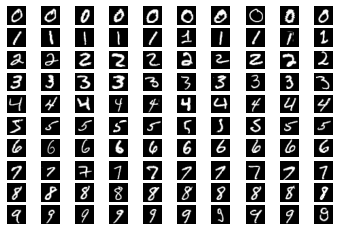

In [ ]:
print('Original images')
f,a=plt.subplots(10,10)
for i in range(10):
 for j in range(10):
    a[i][j].imshow(value[list_of_imgs[i][j]].reshape(28,28),cmap='gray')
    a[i][j].axis('off')
plt.show()

In [ ]:
flat_inp=[]
for i in range(10):
  for j in range(10):
    v=value[list_of_imgs[i][j]][:,9:19,9:19]
    v=v.flatten(start_dim=1)
    flat_inp.append(v)



In [ ]:
flat_inp=torch.cat(flat_inp)

In [ ]:
flat_inp.shape

torch.Size([100, 100])

In [ ]:
flat_inp

tensor([[-1.0000, -0.6000,  0.8667,  ..., -0.6235,  0.2941,  0.9765],
        [-1.0000, -0.2784,  0.9843,  ..., -1.0000, -0.6863,  0.7020],
        [-1.0000, -1.0000, -1.0000,  ...,  0.9686,  0.9686,  0.9686],
        ...,
        [ 0.9843,  0.6706, -0.7490,  ...,  0.6863, -0.8275, -1.0000],
        [-1.0000, -0.8353,  0.0353,  ..., -0.4510, -1.0000, -1.0000],
        [-0.0902,  1.0000,  0.8196,  ..., -1.0000, -1.0000, -1.0000]])

In [ ]:
#flat_inp=flat_inp.view(100,100)
flat_inp.shape

torch.Size([100, 100])

In [ ]:
flat_inp=flat_inp.cuda()

In [ ]:
with torch.no_grad():
  noise = torch.randn(100,100).cuda()
  inp=torch.cat([noise,flat_inp],axis=1)
  generated_data = gen.forward(inp).cpu().view(100, 28, 28)


Without Regularization


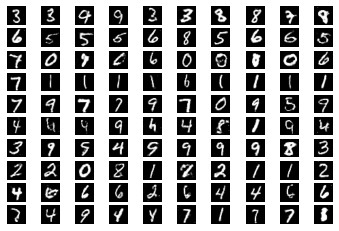

In [ ]:
print("Without Regularization")
ind=0
f,a=plt.subplots(10,10)
for i in range(10):
 for j in range(10):
    a[i][j].imshow(generated_data[ind,:,:],cmap='gray')
    a[i][j].axis('off')
    ind+=1

In [ ]:
mse=nn.MSELoss()

In [ ]:

no_of_epochs=300


real_acc_list=[]
fake_acc_list=[]

for i in range(no_of_epochs):
  length1=0
  length2=0
  acc_fake=0
  acc_real=0
  for num,dat in enumerate(trainc):
    dis.train()
    noise_input=torch.randn(50,100).cuda()
    val,ind=dat
    val=val.cuda()
    ind=ind.cuda()
    val=val.view(50,28,28)
    val=val[:,9:19,9:19]
    val=val.flatten(1,2)
    noise_inp=torch.cat([noise_input,val],dim=1)
    noise_labels=torch.randint(0,10,(50,)).cuda()
    gen_output=gen.forward(noise_inp)
    im,la=dat
    dis_input=im.view(50,784).cuda()
    dis_labels=la.cuda()
    t_labels=torch.ones(50).cuda()
    dis_optim.zero_grad()
    dis_output_t=dis.forward(dis_input).view(50)
    acc_re=torch.round(dis_output_t)
    length2+=dis_labels.size(0)
    acc_real+=(torch.sum(acc_re).item())
    dis_loss_t=loss(dis_output_t,t_labels)
    dis_output_g=dis.forward(gen_output).view(50)
    acc_fa=torch.round(dis_output_g)
    acc_fake+=(torch.sum(acc_fa).item())
    length1+=noise_labels.size(0)
    dis_loss_g=loss(dis_output_g,torch.zeros(50).cuda())
    dis_total_loss=(dis_loss_t+dis_loss_g)/2


    dis_total_loss.backward()
    dis_optim.step()
    

    gen.train()
    gen_optim.zero_grad()
    gen_output=gen.forward(noise_inp)
    #print(gen_output.shape)
    unflattened_gen=gen_output.unflatten(1,(28,28))
    unflattened_gen=unflattened_gen[:,9:19,9:19]
    flat_gen=unflattened_gen.flatten()
    v=val.flatten()
    #print(val.shape)
    #print(flat_gen.shape)h
    lambda_reg=0.1
    centre_patch_loss=mse(flat_gen,v)

    dis_output_g=dis.forward(gen_output).view(50)
    gen_loss=loss(dis_output_g,t_labels) + lambda_reg*centre_patch_loss
    gen_loss.backward()
    gen_optim.step()

  real_acc_list.append(acc_real/length2)
  fake_acc_list.append(acc_fake/length1)  




  print("epoch {} done and the discriminator loss and generator loss are {},  {} respectively ".format(i,dis_total_loss,gen_loss))

epoch 0 done and the discriminator loss and generator loss are 0.5030685067176819,  1.3621611595153809 respectively 
epoch 1 done and the discriminator loss and generator loss are 0.4244987964630127,  1.6815141439437866 respectively 
epoch 2 done and the discriminator loss and generator loss are 0.45412391424179077,  1.8064223527908325 respectively 
epoch 3 done and the discriminator loss and generator loss are 0.4528846740722656,  1.4395581483840942 respectively 
epoch 4 done and the discriminator loss and generator loss are 0.6449612379074097,  1.5808074474334717 respectively 
epoch 5 done and the discriminator loss and generator loss are 0.5285340547561646,  1.556243658065796 respectively 
epoch 6 done and the discriminator loss and generator loss are 0.4159180223941803,  1.4025119543075562 respectively 
epoch 7 done and the discriminator loss and generator loss are 0.5116946697235107,  1.5089279413223267 respectively 
epoch 8 done and the discriminator loss and generator loss are 0

In [ ]:
with torch.no_grad():
  noise = torch.randn(100,100).cuda()
  inp=torch.cat([noise,flat_inp],axis=1)
  generated_data1 = gen(inp).cpu().view(100, 28, 28)


With Regularization, lambda=0.1


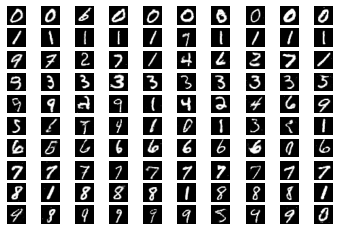

In [ ]:
print("With Regularization, lambda=0.1")
ind=0
f,a=plt.subplots(10,10)
for i in range(10):
 for j in range(10):
    a[i][j].imshow(generated_data1  [ind,:,:],cmap='gray')
    a[i][j].axis('off')
    ind+=1

In [ ]:

no_of_epochs=300


real_acc_list=[]
fake_acc_list=[]

for i in range(no_of_epochs):
  length1=0
  length2=0
  acc_fake=0
  acc_real=0
  for num,dat in enumerate(trainc):
    dis.train()
    noise_input=torch.randn(50,100).cuda()
    val,ind=dat
    val=val.cuda()
    ind=ind.cuda()
    val=val.view(50,28,28)
    val=val[:,9:19,9:19]
    val=val.flatten(1,2)
    noise_inp=torch.cat([noise_input,val],dim=1)
    noise_labels=torch.randint(0,10,(50,)).cuda()
    gen_output=gen.forward(noise_inp)
    im,la=dat
    dis_input=im.view(50,784).cuda()
    dis_labels=la.cuda()
    t_labels=torch.ones(50).cuda()
    dis_optim.zero_grad()
    dis_output_t=dis.forward(dis_input).view(50)
    acc_re=torch.round(dis_output_t)
    length2+=dis_labels.size(0)
    acc_real+=(torch.sum(acc_re).item())
    dis_loss_t=loss(dis_output_t,t_labels)
    dis_output_g=dis.forward(gen_output).view(50)
    acc_fa=torch.round(dis_output_g)
    acc_fake+=(torch.sum(acc_fa).item())
    length1+=noise_labels.size(0)
    dis_loss_g=loss(dis_output_g,torch.zeros(50).cuda())
    dis_total_loss=(dis_loss_t+dis_loss_g)/2


    dis_total_loss.backward()
    dis_optim.step()
    

    gen.train()
    gen_optim.zero_grad()
    gen_output=gen.forward(noise_inp)
    #print(gen_output.shape)
    unflattened_gen=gen_output.unflatten(1,(28,28))
    unflattened_gen=unflattened_gen[:,9:19,9:19]
    flat_gen=unflattened_gen.flatten()
    v=val.flatten()
    #print(val.shape)
    #print(flat_gen.shape)h
    lambda_reg=10
    centre_patch_loss=mse(flat_gen,v)

    dis_output_g=dis.forward(gen_output).view(50)
    gen_loss=loss(dis_output_g,t_labels) + lambda_reg*centre_patch_loss
    gen_loss.backward()
    gen_optim.step()

  real_acc_list.append(acc_real/length2)
  fake_acc_list.append(acc_fake/length1)  




  print("epoch {} done and the discriminator loss and generator loss are {},  {} respectively ".format(i,dis_total_loss,gen_loss))

epoch 0 done and the discriminator loss and generator loss are 0.4267483949661255,  2.8829002380371094 respectively 
epoch 1 done and the discriminator loss and generator loss are 0.5060283541679382,  2.423503875732422 respectively 
epoch 2 done and the discriminator loss and generator loss are 0.5319535732269287,  2.194270372390747 respectively 
epoch 3 done and the discriminator loss and generator loss are 0.39884865283966064,  2.094973564147949 respectively 
epoch 4 done and the discriminator loss and generator loss are 0.5114378333091736,  2.490424394607544 respectively 
epoch 5 done and the discriminator loss and generator loss are 0.42263486981391907,  2.2262048721313477 respectively 
epoch 6 done and the discriminator loss and generator loss are 0.43868160247802734,  2.3931736946105957 respectively 
epoch 7 done and the discriminator loss and generator loss are 0.40767449140548706,  2.390526533126831 respectively 
epoch 8 done and the discriminator loss and generator loss are 0.

In [ ]:
with torch.no_grad():
  noise = torch.randn(100,100).cuda()
  inp=torch.cat([noise,flat_inp],axis=1)
  generated_data2 = gen(inp).cpu().view(100, 28, 28)

With Regularization, lambda=10


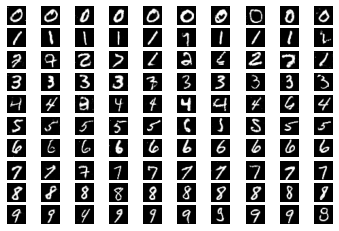

In [ ]:
print("With Regularization, lambda=10")
ind=0
f,a=plt.subplots(10,10)
for i in range(10):
 for j in range(10):
    a[i][j].imshow(generated_data2 [ind,:,:],cmap='gray')
    a[i][j].axis('off')
    ind+=1